In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score

import torch
import torch_geometric.transforms as T
from torch_geometric import seed_everything
from torch_geometric.nn import GCNConv
from torch_geometric.nn import Node2Vec
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import negative_sampling


seed_everything(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      add_negative_train_samples=False),
])

dataset = 'Cora'
path = 'data/Planetoid'
dataset = Planetoid(path, dataset, transform=transform)
# After applying the `RandomLinkSplit` transform, the data is transformed from
# a data object to a list of tuples (train_data, val_data, test_data), with
# each element representing the corresponding split.
train_data, val_data, test_data = dataset[0]

# Traditional Link Prediction based on Local Information

In [2]:
import networkx as nx

# Graph Creation
raw_cora_dataset = Planetoid(path, 'Cora', transform=None)
cora_data = raw_cora_dataset[0]

node_list = [i for i in range(2708)]
edge_list = [list(i) for i in cora_data.edge_index.t().numpy()]
val_edge_list = [list(i) for i in val_data.edge_label_index.t().numpy()]
test_edge_list = [list(i) for i in test_data.edge_label_index.t().numpy()]

G = nx.Graph()
G.add_nodes_from(node_list)
G.add_edges_from(edge_list)
G.remove_edges_from(val_edge_list)
G.remove_edges_from(test_edge_list)

print(nx.info(G))
print("number of test edges: ", str(int(len(test_edge_list)/2)))

Graph with 2708 nodes and 4523 edges
number of test edges:  527


In [3]:
def jaccard_coefficient_link_prediction(G, test_edge_list, verbose=False):
    preds = nx.jaccard_coefficient(G, test_edge_list)
    out = []
    for u, v, p in preds:
        out.append(p)
        if verbose:
            print(f"({u}, {v}) -> {p:.8f}")
    return roc_auc_score(test_data.edge_label.cpu().numpy(), out)
            
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def common_neighbors_link_prediction(G, test_edge_list):
    out = []
    for edge in test_edge_list:
        out.append(sigmoid(len(list(nx.common_neighbors(G, edge[0], edge[1])))))
    return roc_auc_score(test_data.edge_label.cpu().numpy(), out)

def adamic_adar_index_link_prediction(G, test_edge_list, verbose=False):
    preds = nx.adamic_adar_index(G, test_edge_list)
    out = []
    for u, v, p in preds:
        out.append(p)
        if verbose:
            print(f"({u}, {v}) -> {p:.8f}")
    return roc_auc_score(test_data.edge_label.cpu().numpy(), out)

In [4]:
jc_auc = jaccard_coefficient_link_prediction(G, test_edge_list)
print(f'Jaccard Coefficient based Link Prediction AUC: {jc_auc:.4f}')
print('*'*50)
cn_auc = common_neighbors_link_prediction(G, test_edge_list)
print(f'Common Neighbors based Link Prediction AUC: {cn_auc:.4f}')
print('*'*50)
aai_auc = adamic_adar_index_link_prediction(G, test_edge_list)
print(f'Adamic Adar Index based Link Prediction AUC: {aai_auc:.4f}')

Jaccard Coefficient based Link Prediction AUC: 0.7273
**************************************************
Common Neighbors based Link Prediction AUC: 0.7285
**************************************************
Adamic Adar Index based Link Prediction AUC: 0.7298


# Link Prediction based on Node Feature Similarity

In [5]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

In [6]:
def feature_similarity_link_prediction(features, test_edge_list, sim_metric='cosine'):
    if sim_metric == 'cosine':
        sim_matrix = cosine_similarity(features)
    elif sim_metric == 'euclidean':
        dist_matrix = euclidean_distances(features)
        sim_matrix = 1 - dist_matrix
    else:
        print("sim metric error. Please use 'cosine' or 'euclidean'")
        return None
    out = []
    for edge in test_edge_list:
        out.append(sim_matrix[edge[0]][edge[1]])
    return roc_auc_score(test_data.edge_label.cpu().numpy(), out)

In [7]:
features = train_data.x.numpy()
feat_sim_auc = feature_similarity_link_prediction(features, test_edge_list, sim_metric='cosine')
print(f'Node Feature Similarity based Link Prediction AUC: {feat_sim_auc:.4f}')

Node Feature Similarity based Link Prediction AUC: 0.8023


# DeepWalk or node2vec for link prediction

Epoch: 01, Loss: 7.5073, Node Classification Acc: 0.1520
Epoch: 02, Loss: 5.6269, Node Classification Acc: 0.1700
Epoch: 03, Loss: 4.6696, Node Classification Acc: 0.1890
Epoch: 04, Loss: 3.9595, Node Classification Acc: 0.2060
Epoch: 05, Loss: 3.3887, Node Classification Acc: 0.2350
Epoch: 06, Loss: 2.9065, Node Classification Acc: 0.2560
Epoch: 07, Loss: 2.5191, Node Classification Acc: 0.2700
Epoch: 08, Loss: 2.1975, Node Classification Acc: 0.2820
Epoch: 09, Loss: 1.9386, Node Classification Acc: 0.2870
Epoch: 10, Loss: 1.7348, Node Classification Acc: 0.2950
Epoch: 11, Loss: 1.5601, Node Classification Acc: 0.3110
Epoch: 12, Loss: 1.4223, Node Classification Acc: 0.3240
Epoch: 13, Loss: 1.3074, Node Classification Acc: 0.3450
Epoch: 14, Loss: 1.2195, Node Classification Acc: 0.3710
Epoch: 15, Loss: 1.1447, Node Classification Acc: 0.3890
Epoch: 16, Loss: 1.0880, Node Classification Acc: 0.4060
Epoch: 17, Loss: 1.0408, Node Classification Acc: 0.4220
Epoch: 18, Loss: 1.0041, Node C

D:\anaconda\envs\pyg_env\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\anaconda\envs\pyg_env\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


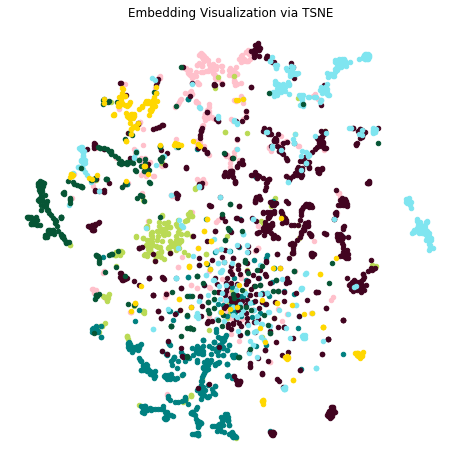

In [8]:
# when setting p=q=1, node2vec is equivalent to deepwalk
deepwalk = Node2Vec(train_data.edge_index, embedding_dim=128, walk_length=20,
                     context_size=10, walks_per_node=10,
                     num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = deepwalk.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(list(deepwalk.parameters()), lr=0.01)

def train_deepwalk():
    deepwalk.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = deepwalk.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

@torch.no_grad()
def test_deepwalk():
    deepwalk.eval()
    z = deepwalk()
    acc = deepwalk.test(z[train_data.train_mask], train_data.y[train_data.train_mask],
                     z[train_data.test_mask], train_data.y[train_data.test_mask],
                     max_iter=150)
    return acc

for epoch in range(1, 101):
    loss = train_deepwalk()
    acc = test_deepwalk()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Node Classification Acc: {acc:.4f}')

@torch.no_grad()
def plot_points(colors):
    deepwalk.eval()
    z = deepwalk(torch.arange(train_data.num_nodes, device=device))
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = train_data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    plt.title('Embedding Visualization via TSNE')
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()

colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535',
    '#ffd700'
]

plot_points(colors)

In [9]:
@torch.no_grad()
def eval_link_prediction(data):
    deepwalk.eval()
    z = deepwalk()
    out = (z[data.edge_label_index[0]] * z[data.edge_label_index[1]]).sum(dim=-1)
    out = out.view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

In [10]:
final_test_auc = eval_link_prediction(test_data)
print(f'Final Test AUC: {final_test_auc:.4f}')

Final Test AUC: 0.8944


# GCN for link prediction

In [11]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()


gcn = GCN(dataset.num_features, 128, 64).to(device)
optimizer = torch.optim.Adam(params=gcn.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()


def train_gcn():
    gcn.train()
    optimizer.zero_grad()
    z = gcn.encode(train_data.x, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = gcn.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test_gcn(data):
    gcn.eval()
    z = gcn.encode(data.x, data.edge_index)
    out = gcn.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train_gcn()
    val_auc = test_gcn(val_data)
    test_auc = test_gcn(test_data)
    if val_auc > best_val_auc:
        best_val = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test AUC: {final_test_auc:.4f}')

# z = gcn.encode(test_data.x, test_data.edge_index)
# final_edge_index = gcn.decode_all(z)

Epoch: 001, Loss: 0.6930, Val: 0.7319, Test: 0.7529
Epoch: 002, Loss: 0.6820, Val: 0.7241, Test: 0.7491
Epoch: 003, Loss: 0.7089, Val: 0.7258, Test: 0.7573
Epoch: 004, Loss: 0.6769, Val: 0.7301, Test: 0.7642
Epoch: 005, Loss: 0.6847, Val: 0.7439, Test: 0.7819
Epoch: 006, Loss: 0.6878, Val: 0.7664, Test: 0.8012
Epoch: 007, Loss: 0.6885, Val: 0.7646, Test: 0.7968
Epoch: 008, Loss: 0.6874, Val: 0.7506, Test: 0.7836
Epoch: 009, Loss: 0.6845, Val: 0.7365, Test: 0.7716
Epoch: 010, Loss: 0.6791, Val: 0.7266, Test: 0.7618
Epoch: 011, Loss: 0.6719, Val: 0.7197, Test: 0.7543
Epoch: 012, Loss: 0.6692, Val: 0.7121, Test: 0.7464
Epoch: 013, Loss: 0.6725, Val: 0.7079, Test: 0.7408
Epoch: 014, Loss: 0.6624, Val: 0.7147, Test: 0.7428
Epoch: 015, Loss: 0.6552, Val: 0.7435, Test: 0.7609
Epoch: 016, Loss: 0.6513, Val: 0.7677, Test: 0.7756
Epoch: 017, Loss: 0.6452, Val: 0.7674, Test: 0.7752
Epoch: 018, Loss: 0.6342, Val: 0.7551, Test: 0.7672
Epoch: 019, Loss: 0.6220, Val: 0.7545, Test: 0.7670
Epoch: 020, 

# Final Results

| Link Prediction Methods | AUC |
| :--- | :---: |
| Local Information - Jaccard Coeffecient | 0.7273 |
| Local Information - Common Neighbors | 0.7285 |
| Local Information - Adamic Adar Index | 0.7298 |
| Node Feature Similarity | 0.8023 |
| DeepWalk | 0.8944 |
| GCN | 0.9213 |